# Hypermorph notebook

In [1]:
import os
# os.environ["CUDA_VISIBLE_DEVICES"] = "1"
# suppress info and warn TF logs
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import gc
import time
import cv2
import tifffile as tiff
import numpy as np
import matplotlib
import nibabel as nib
import neurite as ne
import voxelmorph as vxm
import stabilize2p
import mpl_toolkits.axisartist as AA
import matplotlib.colors as mcolors
from matplotlib import pyplot as plt
from IPython.display import Video

plt.rcParams["animation.html"] = "jshtml" 
plt.rcParams["animation.embed_limit"] = "500"  # size limit in MB

# Font size
plt.style.use('default')

SMALL_SIZE = 15
MEDIUM_SIZE = 20
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('axes', titlesize=BIGGER_SIZE)    # fontsize of the axes title
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

%reload_ext autoreload
%autoreload 2
%matplotlib notebook
%matplotlib inline

from stabilize2p.utils import make_video

def frame_gen(video, scores=None, lt=0.9):
    low, hig = video[0].min(), video[1].max()
    if scores is not None:
        for img, score in zip(video, scores):
            img = (img - low) / (hig - low) * 255
            img[img < 0] = 0
            img[img > 255] = 255
            img = img.astype(np.uint8)
            if score < lt:
                img[:50, :50] = 255
            else:
                img[:50, :50] = 0
            yield img
    else:
        for img in video:
            img = (img - low) / (hig - low) * 255
            img[img < 0] = 0
            img[img > 255] = 255
            img = img.astype(np.uint8)
            yield img

orig_examples = [
    '../data/200901_G23xU1/Fly1/Fly1/001_coronal/2p/denoised_red.tif',
    '../data/200901_G23xU1/Fly1/Fly1/002_coronal/2p/denoised_red.tif',
    '../data/200901_G23xU1/Fly1/Fly1/003_coronal/2p/denoised_red.tif',
    '../data/200901_G23xU1/Fly1/Fly1/004_coronal/2p/denoised_red.tif',
    '../data/200901_G23xU1/Fly1/Fly1/005_coronal/2p/denoised_red.tif',
    '../data/200901_G23xU1/Fly1/Fly1/006_coronal/2p/denoised_red.tif',
    '../data/200901_G23xU1/Fly1/Fly1/007_coronal/2p/denoised_red.tif',
    '../data/200901_G23xU1/Fly1/Fly1/008_coronal/2p/denoised_red.tif',
    '../data/200901_G23xU1/Fly1/Fly1/009_coronal/2p/denoised_red.tif'
]

ofco_examples = [
    '../data/200901_G23xU1/Fly1/Fly1/001_coronal/2p/warped_red.tif',
    '../data/200901_G23xU1/Fly1/Fly1/002_coronal/2p/warped_red.tif',
    '../data/200901_G23xU1/Fly1/Fly1/003_coronal/2p/warped_red.tif',
    '../data/200901_G23xU1/Fly1/Fly1/004_coronal/2p/warped_red.tif',
    '../data/200901_G23xU1/Fly1/Fly1/005_coronal/2p/warped_red.tif'
]

pystackreg_examples = [
    '../data/200901_G23xU1/Fly1/Fly1/001_coronal/2p/denoised_red.pystackreg-affine.tif',
    '../data/200901_G23xU1/Fly1/Fly1/002_coronal/2p/denoised_red.pystackreg-affine.tif',
    '../data/200901_G23xU1/Fly1/Fly1/003_coronal/2p/denoised_red.pystackreg-affine.tif',
    '../data/200901_G23xU1/Fly1/Fly1/004_coronal/2p/denoised_red.pystackreg-affine.tif',
    '../data/200901_G23xU1/Fly1/Fly1/005_coronal/2p/denoised_red.pystackreg-affine.tif',
    '../data/200901_G23xU1/Fly1/Fly1/006_coronal/2p/denoised_red.pystackreg-affine.tif',
    '../data/200901_G23xU1/Fly1/Fly1/007_coronal/2p/denoised_red.pystackreg-affine.tif',
    '../data/200901_G23xU1/Fly1/Fly1/008_coronal/2p/denoised_red.pystackreg-affine.tif',
    '../data/200901_G23xU1/Fly1/Fly1/009_coronal/2p/denoised_red.pystackreg-affine.tif',
]

RANDOM_SEED = 1

os.makedirs('report', exist_ok=True)

# Load model

In [40]:
weights_path = '../models/hypm_drosophila_2d_0100.h5'

# get shape
inshape = tiff.imread(orig_examples[0], key=0).shape
nfeats = 1
print(f'{inshape=}')

# build model
vxm_model = vxm.networks.HyperVxmDense.load(weights_path)
print('input shape:  ' + ', '.join([str(t.shape) for t in vxm_model.inputs]))
print('output shape: ' + ', '.join([str(t.shape) for t in vxm_model.outputs]))

# tensorflow device handling
device, nb_devices = vxm.tf.utils.setup_device('0')

# multi-gpu support
if nb_devices > 1:
    vxm_model = tf.keras.utils.multi_gpu_model(vxm_model, gpus=nb_devices)

# print model info
vxm_model.summary(line_length=180)

inshape=(480, 736)
input shape:  (None, 480, 736, 1), (None, 480, 736, 1), (None, 1)
output shape: (None, 480, 736, 1), (None, 240, 368, 2)
Model: "hyper_vxm_dense"
____________________________________________________________________________________________________________________________________________________________________________________
 Layer (type)                                              Output Shape                            Param #              Connected to                                                
 hyper_vxm_dense_hyp_input (InputLayer)                    [(None, 1)]                             0                    []                                                          
                                                                                                                                                                                    
 hyper_vxm_dense_hyp_dense_1 (Dense)                       (None, 128)                             256         

## Register image

prepare validation tensor,

In [9]:
image_path = orig_examples[4]
keys = [range(50)]

store_params = []
base_gen = stabilize2p.utils.vxm_data_generator(image_path,
                                                keys=keys,
                                                training=False,
                                                store_params=store_params)
validation = [inputs for (inputs, _) in base_gen]

del base_gen
gc.collect()

moving = np.concatenate([m for m, _ in validation], axis=0)
fixed = np.concatenate([f for _, f in validation], axis=0)

del validation
gc.collect()

print(f'{moving.shape=} | {fixed.shape=}')

[2022-01-04 22:39:07,414] I T140225781633856 utils.py:236: Calculated "first" fixed references in 0.295s


moving.shape=(50, 480, 736, 1) | fixed.shape=(50, 480, 736, 1)


In [10]:
# inference
moved = []
t1 = time.perf_counter()
for hyp in np.linspace(0, 1, 20):
    print(f'registering with {hyp=} ..')
    hyp = np.tile([[hyp]], (moving.shape[0], 1)).astype('float32')  # reformat hyperparam

    # prepare for model inference
    inputs = (moving, fixed, hyp)
    img = vxm_model.predict(inputs)[0].squeeze()
    moved += [img]
t2 = time.perf_counter()
print(f'Elapsed {t2-t1:.2f}s | {20*moving.shape[0]/(t2-t1):.0f} frames/s | {(t2-t1)/(20*moving.shape[0]):.2f} s/frame')

moved = np.stack(moved, axis=-1)
print(f'{moved.shape=}')

registering with hyp=0.0 ..
registering with hyp=0.05263157894736842 ..
registering with hyp=0.10526315789473684 ..
registering with hyp=0.15789473684210525 ..
registering with hyp=0.21052631578947367 ..
registering with hyp=0.2631578947368421 ..
registering with hyp=0.3157894736842105 ..
registering with hyp=0.3684210526315789 ..
registering with hyp=0.42105263157894735 ..
registering with hyp=0.47368421052631576 ..
registering with hyp=0.5263157894736842 ..
registering with hyp=0.5789473684210527 ..
registering with hyp=0.631578947368421 ..
registering with hyp=0.6842105263157894 ..
registering with hyp=0.7368421052631579 ..
registering with hyp=0.7894736842105263 ..
registering with hyp=0.8421052631578947 ..
registering with hyp=0.894736842105263 ..
registering with hyp=0.9473684210526315 ..
registering with hyp=1.0 ..
Elapsed 51.80s | 19 frames/s | 0.05 s/frame
moved.shape=(50, 480, 736, 20)


GPU (50 frames; 20 hyp): `Elapsed 51.80s | 19 frames/s | 0.05 s/frame` <br/>
CPU (50 frames; 20 hyp): `Elapsed 51.41s | 19 frames/s | 0.05 s/frame`

plot results,

plotting different outputs for frame 0


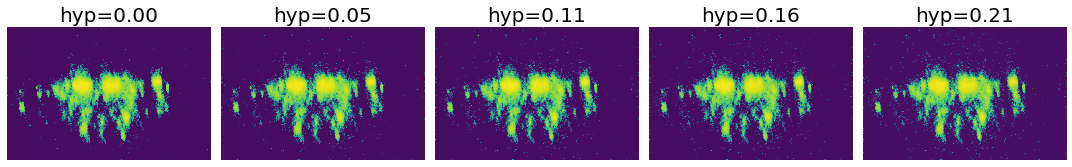

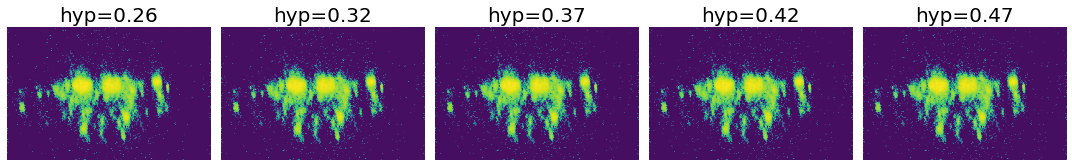

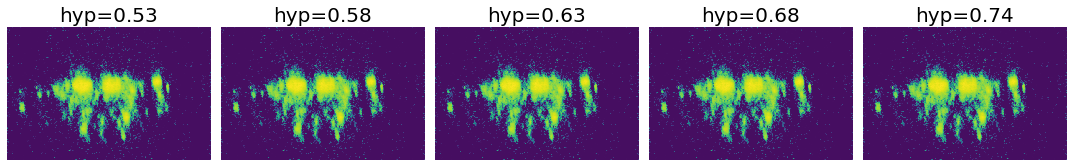

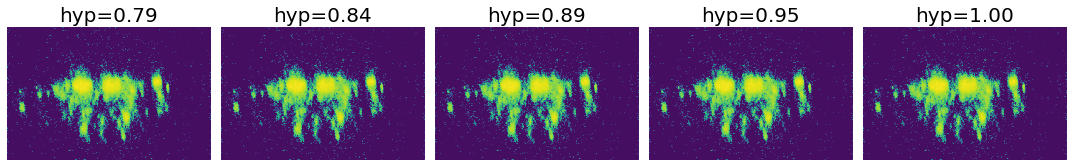

In [11]:
sample_i = 0
N = 5

print(f'plotting different outputs for frame {sample_i}')

for k in range(0, 20, N):
    images = [moved[sample_i, ..., i] for i in range(k, k+N)]
    titles = [f'hyp={i/19:.2f}' for i in range(k, k+N)]
    cmaps = ['viridis'] * N
    ne.plot.slices(images, titles=titles, cmaps=cmaps);

evaluate metrics,

In [21]:
from stabilize2p.metrics import MSE, COM, NCC, EMD
metrics = [MSE, COM, NCC, EMD]
scores = {v.__name__: [] for v in metrics}
scores['EMD-std'] = []

for i, hyp in enumerate(np.linspace(0, 1, 20)):
    print('-'*32)
    for func in metrics:
        t1 = time.perf_counter()
        if func.__name__ == 'EMD':
            score = [func(moved[..., i]) for _ in range(5)]
        else:
            score = func(moved[..., i])
        t2 = time.perf_counter()
        if func.__name__ == 'EMD':
            print(f'hyp: {hyp:.2f} | {t2-t1:.3f}s | {func.__name__}: {np.mean(score)} ± {np.std(score)}')
            scores[func.__name__] += [np.mean(score)]
            scores[func.__name__+'-std'] += [np.std(score)]
        else:
            print(f'hyp: {hyp:.2f} | {t2-t1:.3f}s | {func.__name__}: {score}')
            scores[func.__name__] += [score]

--------------------------------
hyp: 0.00 | 0.184s | MSE: 0.010673092678189278
hyp: 0.00 | 0.117s | COM: 0.0
hyp: 0.00 | 1.200s | NCC: -0.4777093529701233
hyp: 0.00 | 15.662s | EMD: 21.91361335761417 ± 0.257591496632556
--------------------------------
hyp: 0.05 | 0.183s | MSE: 0.010896927677094936
hyp: 0.05 | 0.117s | COM: 0.0
hyp: 0.05 | 1.204s | NCC: -0.3768947720527649
hyp: 0.05 | 15.348s | EMD: 21.00510837614272 ± 0.1603591289543148
--------------------------------
hyp: 0.11 | 0.185s | MSE: 0.01099822111427784
hyp: 0.11 | 0.116s | COM: 0.0
hyp: 0.11 | 1.206s | NCC: -0.3510352671146393
hyp: 0.11 | 14.789s | EMD: 19.929294461838424 ± 0.2775724804568463
--------------------------------
hyp: 0.16 | 0.184s | MSE: 0.01108232606202364
hyp: 0.16 | 0.117s | COM: 0.0
hyp: 0.16 | 1.208s | NCC: -0.33493566513061523
hyp: 0.16 | 15.253s | EMD: 20.572068638503946 ± 0.23857293552207742
--------------------------------
hyp: 0.21 | 0.183s | MSE: 0.011151001788675785
hyp: 0.21 | 0.117s | COM: 0.0
h

MSE | min:     0.010673 hyp: 0.000000 | max:     0.011520 hyp: 1.000000
COM | min:     0.000000 hyp: 0.000000 | max:     0.000000 hyp: 0.000000
NCC | min:    -0.477709 hyp: 0.000000 | max:    -0.276170 hyp: 1.000000
EMD | min:    19.354278 hyp: 0.368421 | max:    21.913613 hyp: 0.000000
EMD-std | min:     0.092502 hyp: 0.684211 | max:     0.560808 hyp: 0.842105


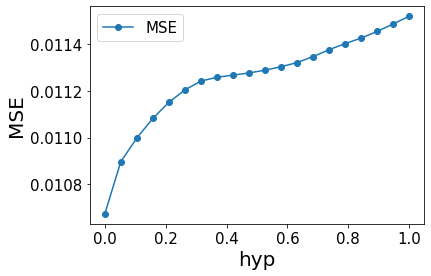

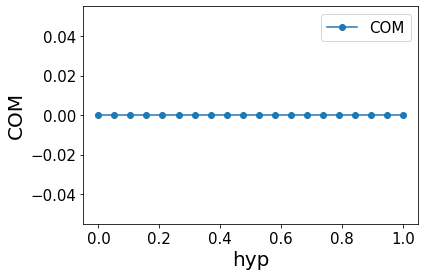

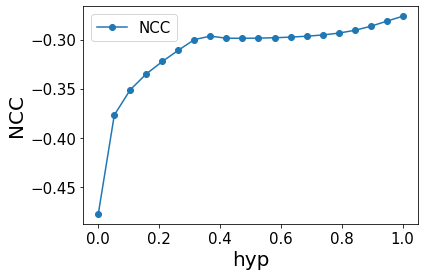

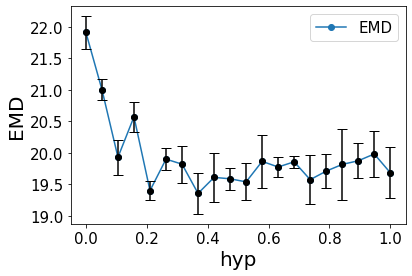

In [22]:
hyp_array = np.linspace(0, 1, 20)

def plot_score(name, values, err=None):
    _, ax = plt.subplots(1, 1, figsize=(6, 4))
    ax.plot(hyp_array, values, '-o', color='tab:blue', label=name)
    if err:
        ax.errorbar(hyp_array, values, err, color='k', fmt='o', capsize=5.0)
    ax.set_xlabel('hyp')
    ax.set_ylabel(name)
    ax.legend()

for k, v in scores.items():
    min_hyp = hyp_array[np.argmin(v)]
    max_hyp = hyp_array[np.argmax(v)]
    print(f'{k} | min: {np.min(v):12f} hyp: {min_hyp:2f} | max: {np.max(v):12f} hyp: {max_hyp:2f}')

for k, v in scores.items():
    if k == 'EMD-std':
        continue
    err = scores['EMD-std'] if k == 'EMD' else None
    plot_score(k, v, err=err)

## Hyperparameter weights the losses

The hyper-parameter of the model actually acts as a weight for the losses. $1-\lambda$ for the similarity loss and $\lambda$ for the flow gradient smoothness loss.

We will thus manually set $\lambda$ to a value that makes more intuitive sense.

In [46]:
# load example
image_path = orig_examples[4]
keys = [range(50)]

store_params = []
base_gen = stabilize2p.utils.vxm_data_generator(image_path,
                                                keys=keys,
                                                training=False,
                                                store_params=store_params)
validation = [inputs for (inputs, _) in base_gen]

del base_gen
gc.collect()

moving = np.concatenate([m for m, _ in validation], axis=0)
fixed = np.concatenate([f for _, f in validation], axis=0)

del validation
gc.collect()

print(f'{moving.shape=} | {fixed.shape=}')

[2022-01-06 02:08:07,322] I T140116948562752 utils.py:431: Calculated "first" fixed references in 0.288s


moving.shape=(50, 480, 736, 1) | fixed.shape=(50, 480, 736, 1)


In [49]:
# hyper-parameter weights the flow gradient smoothness loss
hyp = 0.8

# inference
moved = []
t1 = time.perf_counter()

print(f'registering with {hyp=} ..')
hyp = np.tile([[hyp]], (moving.shape[0], 1)).astype('float32')  # reformat hyperparam
moved = vxm_model.predict((moving, fixed, hyp))[0].squeeze()
# undo pre-processing transformations
moved = stabilize2p.utils.vxm_undo_preprocessing(moved, store_params[0])

t2 = time.perf_counter()
print(f'Elapsed {t2-t1:.2f}s | {20*moving.shape[0]/(t2-t1):.0f} frames/s | {(t2-t1)/(20*moving.shape[0]):.2f} s/frame')

print(f'{moved.shape=}')

registering with hyp=0.8 ..
Elapsed 2.56s | 391 frames/s | 0.00 s/frame
moved.shape=(50, 480, 736)


show video of the registered results,

In [50]:
make_video('out', frame_gen(moved))
Video('out.mov')

50it [00:00, 334.36it/s]
ffmpeg: /home/adrian/miniconda3/lib/libtinfo.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffmpeg: /home/adrian/miniconda3/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffmpeg: /home/adrian/miniconda3/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)


converting video..
Done (0.19s)


# Choosing best model outputs

For each image, we can register with a different $\lambda$ hyper-parameter, but we do not know which one is the best. In the original paper [[1]](https://arxiv.org/pdf/2101.01035.pdf), they suggest using visual inspection or anatomical annotations. Insead, we will optimize using some heuristic metric so as to minimize:

$$
    \text{min}_{(\lambda_1, ..., \lambda_N)} \sum_t^{N-1} \mathcal{L}_{sim} (I_t, I_{t+1})
$$

Where $I_t$ is generated using $\lambda_t$.

If in the interval $\lambda \in [0, 1]$ we have a resolution of 20 $\lambda$ values, then each pair $(I_t, I_{t+1})$ has $20^2$ combinations of $\mathcal{L}_{sim} (I_t, I_{t+1})$, out of which we have to choose one.

We have a memory complexity of $O(20^2 N)$ to store all combinations.

This, in fact, is the same as solving $20^2$ shortest-weighted-path optimization problems (for each source-sink pair $(I_0, I_N)$) and choosing the shortest weighted one. We can solve each one in parallel.

In [71]:
from stabilize2p.utils import hypermorph_optimal_register

with np.printoptions(precision=3, threshold=np.inf, linewidth=120):
    weights_path = '../models/hypm_drosophila_2d_1100.h5'
    keys = [range(20)]
    moved = hypermorph_optimal_register(orig_examples[4],
                                        weights_path,
                                        metric='model-ncc',
                                        keys=keys, num_hyp=20)

[2022-01-06 16:48:49,706] I T140632519037760 utils.py:104: model input shape:  (None, 480, 736, 1), (None, 480, 736, 1), (None, 1)
[2022-01-06 16:48:49,707] I T140632519037760 utils.py:105: model output shape: (None, 480, 736, 1), (None, 240, 368, 2)
[2022-01-06 16:48:49,875] I T140632519037760 utils.py:500: Calculated "first" fixed references in 0.167s
100%|█████████████████████████████████████████████████████████████████████████████████| 19/19 [00:42<00:00,  2.25s/it]
[2022-01-06 16:49:35,720] I T140632519037760 utils.py:222: Calcuated scores. Elapsed 45.10s | 0 frames/s | 2.2550 s/frame
[2022-01-06 16:49:35,727] I T140632519037760 utils.py:234: Calcuated shortest paths. Elapsed 0.0069s
[2022-01-06 16:49:35,729] I T140632519037760 utils.py:235: Shortest path scores: 
[[-2.515 -2.991 -3.04  -3.061 -3.078 -3.088 -3.096 -3.102 -3.106 -3.11  -3.112 -3.114 -3.115 -3.116 -3.117 -3.117
  -3.117 -3.117 -3.117 -3.117]
 [-2.661 -3.136 -3.186 -3.206 -3.224 -3.234 -3.241 -3.247 -3.252 -3.255 -3.

In [72]:
make_video('out', frame_gen(moved))
Video('out.mov')

20it [00:00, 432.66it/s]
ffmpeg: /home/adrian/miniconda3/lib/libtinfo.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffmpeg: /home/adrian/miniconda3/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffmpeg: /home/adrian/miniconda3/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)


converting video..
Done (0.19s)


# DELTEME

In [2]:
from stabilize2p.metrics import NCC
path = orig_examples[4]
gen = stabilize2p.utils.vxm_data_generator(path, training=False)
inputs = [ins for (ins, _) in gen]

del gen
gc.collect()

moving = np.concatenate([m for m, _ in inputs], axis=0)
fixed = np.concatenate([f for _, f in inputs], axis=0)

del inputs
gc.collect()

ncc = NCC(moving[:10], ref=fixed[:10])
print(f'NCC: {ncc}')

make_video('example-5', frame_gen(moving))
Video('example-5.mov')

[2022-01-07 07:37:20,247] I T140555389629248 utils.py:500: Calculated "first" fixed references in 18.6s


NCC: -0.5732327103614807


4100it [00:10, 375.52it/s]
ffmpeg: /home/adrian/miniconda3/lib/libtinfo.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffmpeg: /home/adrian/miniconda3/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffmpeg: /home/adrian/miniconda3/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)


converting video..
Done (16.88s)


In [3]:
Video('../bin/train-vxm.ncc.l0.75.out/validation-video.mov')

In [2]:
def gen(orig, moved):
    for i1, i2 in zip(frame_gen(orig), frame_gen(moved)):
        yield np.concatenate([i1, i2], axis=1)


orig = tiff.imread(orig_examples[4])
moved = np.load('../bin/train-vxm.ncc.l0.75.1000.out/validation-video.npy')
moved = moved.squeeze()
make_video('out', gen(orig, moved))
Video('out.mov')

4100it [00:17, 234.72it/s]
ffmpeg: /home/adrian/miniconda3/lib/libtinfo.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffmpeg: /home/adrian/miniconda3/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffmpeg: /home/adrian/miniconda3/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)


converting video..
Done (13.55s)


In [9]:
from stabilize2p.metrics import NCC
from stabilize2p.utils import get_strategy, vxm_data_generator

in_shape = tiff.imread(orig_examples[4], key=0).shape
enc_nf = [16, 32, 32, 128, 128]
dec_nf = [128, 128, 32, 32, 32, 16, 16]
strategy = get_strategy('GPU')
with strategy.scope():
    vxm_model = vxm.networks.VxmDense(in_shape,
                                      [enc_nf, dec_nf],
                                      int_steps=0,  # non-diffeomorphic warp
                                      int_resolution=2)
    vxm_model.load_weights('../models/vxm_drosophila_2d_2000.h5')
print('model input shape:  ' + ', '.join([str(t.shape) for t in vxm_model.inputs]))
print('model output shape: ' + ', '.join([str(t.shape) for t in vxm_model.outputs]))

# retrieve images as input
store_params = []
base_gen = vxm_data_generator(orig_examples[4],
                              training=False,
                              store_params=store_params)
inputs = [ins for (ins, _) in base_gen]

del base_gen
gc.collect()

moving = np.concatenate([m for m, _ in inputs], axis=0)
fixed = np.concatenate([f for _, f in inputs], axis=0)

del inputs
gc.collect()

moved = vxm_model.predict((moving, fixed))[0].squeeze()
print(f'{moved.shape=}')

ncc = NCC(moved)
print(f'{ncc=}')

[2022-01-09 11:25:14,507] I T140216289133376 utils.py:1235: Num Physical GPUs Available: 0
[2022-01-09 11:25:14,507] I T140216289133376 utils.py:1236: Num Logical  GPUs Available: 0
[2022-01-09 11:25:14,507] I T140216289133376 utils.py:1237: Num TPUs Available: 0
[2022-01-09 11:25:14,507] I T140216289133376 utils.py:1267: using default strategy.


model input shape:  (None, 480, 736, 1), (None, 480, 736, 1)
model output shape: (None, 480, 736, 1), (None, 480, 736, 2)


[2022-01-09 11:25:32,519] I T140216289133376 utils.py:512: Calculated "previous" fixed references in 17.9s


moved.shape=(4100, 480, 736)
ncc=-0.606587
